In [1]:
import nltk; 
# nltk.download('stopwords')

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
# import json

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
#matplotlib inline

# Enable logging for gensim 
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

c:\Users\Kartikay Naswa\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


# Stop Words - 
Some examples of stop words are: "a," "and," "but," "how," "or," and "what." While the majority of all Internet search engines utilize stop words, they do not prevent a user from using them, but they are ignored

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','efter'])

In [4]:
df1 = pd.read_csv(r'Reviews.csv')
print(df1.Text.unique())
df = df1[['Text']].iloc[30000:50000].copy()

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.'
 ...
 'These stars are sm

In [5]:
df['Text']

30000    I've taken the gluten-free baking classes from...
30001    This bread mix is the absolutley best replacem...
30002    I really expected to be disappointed, as I had...
30003    I love this stuff! It makes great bread in the...
30004    This GF bread works well in the bread machine....
                               ...                        
49995    My sister introduced me to these. They have be...
49996    A friend recommended these bars and I fell in ...
49997    Fabulous!  I take one to work with me every da...
49998    I love these bars and will continue to buy the...
49999    These are very good; nutritious, great flavor ...
Name: Text, Length: 20000, dtype: object

In [6]:
df['data'] = df.Text.tolist()

In [7]:
df["data"]

30000    I've taken the gluten-free baking classes from...
30001    This bread mix is the absolutley best replacem...
30002    I really expected to be disappointed, as I had...
30003    I love this stuff! It makes great bread in the...
30004    This GF bread works well in the bread machine....
                               ...                        
49995    My sister introduced me to these. They have be...
49996    A friend recommended these bars and I fell in ...
49997    Fabulous!  I take one to work with me every da...
49998    I love these bars and will continue to buy the...
49999    These are very good; nutritious, great flavor ...
Name: data, Length: 20000, dtype: object

In [8]:
# Convert to list
data = df.Text.tolist()

df['data'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in df['data']]
df['data'] = [re.sub('\?', ' ', str(sent)) for sent in df['data']]
df['data'] = [re.sub('\_', ' ', str(sent)) for sent in df['data']]
df['data'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in df['data']]
# Remove new line characters
df['data'] = [re.sub('\s+', ' ', str(sent)) for sent in df['data']]
# Remove distracting single quotes
df['data'] = [re.sub("\'", " ", str(sent)) for sent in df['data']]
df['data']= df['data'].str.lower()

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
#tokens
data_words = list(sent_to_words(data))

print(data_words[:1])

[['ve', 'taken', 'the', 'gluten', 'free', 'baking', 'classes', 'from', 'the', 'cia', 'and', 'although', 'you', 're', 'taught', 'to', 'make', 'good', 'gluten', 'free', 'bread', 'this', 'is', 'much', 'better', 'simply', 'because', 'it', 'is', 'so', 'quick', 'easy', 'you', 'don', 'have', 'to', 'worry', 'about', 'the', 'bread', 'rising', 'br', 'br', 'make', 'sure', 'you', 'use', 'mixer', 'if', 'you', 'try', 'to', 'mix', 'it', 'by', 'hand', 'the', 'bread', 'won', 'rise', 'properly', 'additionally', 'the', 'pizza', 'dough', 'is', 'great', 'with', 'diced', 'olives', 'homemade', 'roasted', 'red', 'peppers', 'basil', 'garlic', 'all', 'in', 'the', 'dough', 'br', 'br', 'finally', 'also', 'allergic', 'to', 'corn', 'soy', 'beans', 'nuts', 'and', 'ton', 'of', 'other', 'stuff', 'so', 'unless', 'make', 'it', 'myself', 'this', 'is', 'my', 'only', 'choice', 'other', 'than', 'some', 'of', 'the', 'namaste', 'products']]


# Unigram, Bigram, Trigram
A unigram is a one-word sequence.The unigrams would simply be: "ve" ,"taken", "the", "gluten" "free" "baking" "classes"

A 2bigram is a two-word sequence of words, like “gluten free”, “baking classes”. 

And a trigram is a three-word sequence of words like “gluten free baking”, “free baking classes”.

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['ve', 'taken', 'the', 'gluten_free', 'baking', 'classes', 'from', 'the', 'cia', 'and', 'although', 'you', 're', 'taught', 'to', 'make', 'good', 'gluten_free_bread', 'this', 'is', 'much', 'better', 'simply', 'because', 'it', 'is', 'so', 'quick', 'easy', 'you', 'don', 'have', 'to', 'worry', 'about', 'the', 'bread', 'rising', 'br', 'br', 'make', 'sure', 'you', 'use', 'mixer', 'if', 'you', 'try', 'to', 'mix', 'it', 'by', 'hand', 'the', 'bread', 'won', 'rise', 'properly', 'additionally', 'the', 'pizza_dough', 'is', 'great', 'with', 'diced', 'olives', 'homemade', 'roasted', 'red', 'peppers', 'basil', 'garlic', 'all', 'in', 'the', 'dough', 'br', 'br', 'finally', 'also', 'allergic', 'to', 'corn', 'soy', 'beans', 'nuts', 'and', 'ton', 'of', 'other', 'stuff', 'so', 'unless', 'make', 'it', 'myself', 'this', 'is', 'my', 'only', 'choice', 'other', 'than', 'some', 'of', 'the', 'namaste', 'products']


# Lemmatization 
It usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['take', 'baking', 'class', 'teach', 'make', 'good', 'gluten_free', 'bread', 'much', 'well', 'simply', 'quick', 'easy', 'worry', 'bread', 'rise', 'make', 'sure', 'mixer', 'try', 'mix', 'hand', 'bread', 'rise', 'properly', 'additionally', 'great', 'dice', 'olive', 'homemade', 'roast', 'red', 'pepper', 'basil', 'garlic', 'dough', 'finally', 'also', 'allergic', 'corn', 'soy', 'bean', 'nuts', 'ton', 'stuff', 'make', 'choice', 'namaste', 'product']]


# Term Document Frequency:

Suppose we have a set of English text documents and wish to rank which document is most relevant to the query , “Data Science is awesome !” A simple way to start out is by eliminating documents that do not contain all three words “Data”,”is”, “Science”, and “awesome”, but this still leaves many documents. To further distinguish them, we might count the number of times each term occurs in each document; the number of times a term occurs in a document is called its term frequency.
T

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1)]]


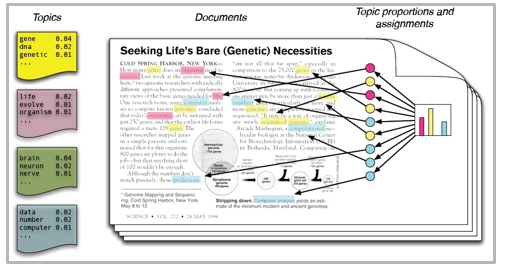

# Topic modeling:

The process of identifying topics in a set of documents. This can be useful for search engines, customer service automation, and any other instance where knowing the topics of documents is important.

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"size" + 0.041*"worth" + 0.036*"banana" + 0.036*"one" + 0.030*"salt" '
  '+ 0.028*"minute" + 0.020*"notice" + 0.017*"carb" + 0.017*"consider" + '
  '0.015*"side"'),
 (1,
  '0.112*"bar" + 0.039*"coffee" + 0.034*"sugar" + 0.031*"protein" + '
  '0.016*"organic" + 0.012*"candy" + 0.012*"milk" + 0.011*"contain" + '
  '0.011*"morning" + 0.010*"warm"'),
 (2,
  '0.067*"product" + 0.045*"find" + 0.038*"buy" + 0.029*"order" + '
  '0.029*"price" + 0.022*"amazon" + 0.019*"purchase" + 0.017*"pack" + '
  '0.017*"store" + 0.016*"box"'),
 (3,
  '0.111*"food" + 0.084*"coconut" + 0.046*"bottle" + 0.044*"cat" + '
  '0.034*"natural" + 0.017*"ingredient" + 0.013*"health" + 0.011*"difference" '
  '+ 0.010*"weight" + 0.009*"feed"'),
 (4,
  '0.075*"tea" + 0.038*"water" + 0.034*"drink" + 0.034*"make" + 0.021*"add" + '
  '0.017*"use" + 0.015*"ginger" + 0.014*"easy" + 0.014*"hot" + 0.013*"mix"'),
 (5,
  '0.038*"taste" + 0.028*"good" + 0.023*"flavor" + 0.020*"get" + 0.019*"try" + '
  '0.019*"great" 

# Perplexity
Given a trained model, perplexity tries to measure how this model is surprised when it is given a new dataset. This is measured as the normalized log-likelihood of the held out test set. The lower the perplexity, the better the model.

# Coherence
The coherence of a topic by measuring the degree of semantic similarity between its high scoring words. 

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.473742188966275

Coherence Score:  0.41235838898645244


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda.html')
vis

c:\Users\Kartikay Naswa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.324758  0.163852       1        1  50.661233
4      0.107412  0.045011       2        1  15.342816
2      0.106538 -0.359533       3        1  15.036720
1     -0.147326  0.204951       4        1   9.955652
3     -0.204250 -0.017165       5        1   5.889908
0     -0.187131 -0.037117       6        1   3.113672, topic_info=            Term         Freq        Total Category  logprob  loglift
1527         bar  7307.000000  7307.000000  Default  30.0000  30.0000
2042         tea  7574.000000  7574.000000  Default  29.0000  29.0000
28       product  6581.000000  6581.000000  Default  28.0000  28.0000
77          food  4265.000000  4265.000000  Default  27.0000  27.0000
1496     coconut  3247.000000  3247.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1500     biscuit   157.332392   158.244161   Topic6  -4.8643   3.4636
716       remove   154.163928   155.061604   Topic6  -4.8847   3.4636
204   satisfying   148.022090   148.924490   Topic6  -4.9253   3.4633
611       please   138.988449   139.889806   Topic6  -4.9883   3.4629
1573      intake   134.165704   135.064506   Topic6  -5.0236   3.4627

[239 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
207       3  0.998842  absolutely
67        2  0.999746         add
274       4  0.998442  aftertaste
253       4  0.998779      almond
2         1  0.868205        also
...     ...       ...         ...
125       2  0.998511   wonderful
898       6  0.998471       worth
337       4  0.997493  www_amazon
245       3  0.999598        year
1415      5  0.995755       young

[226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 2, 4, 1])

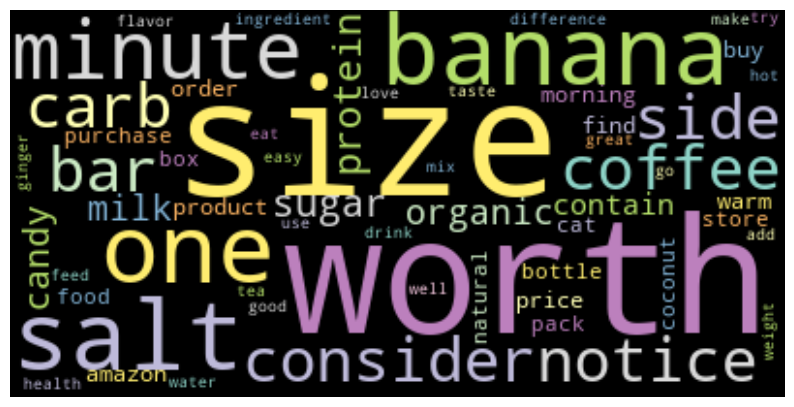

In [18]:
# Show all topics in 1 wordcloud
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in lda_model.print_topics())
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
# plt.figure(1,figsize=(12, 12))
# plt.show()
plt.savefig("wordCloudAllTopic.png")

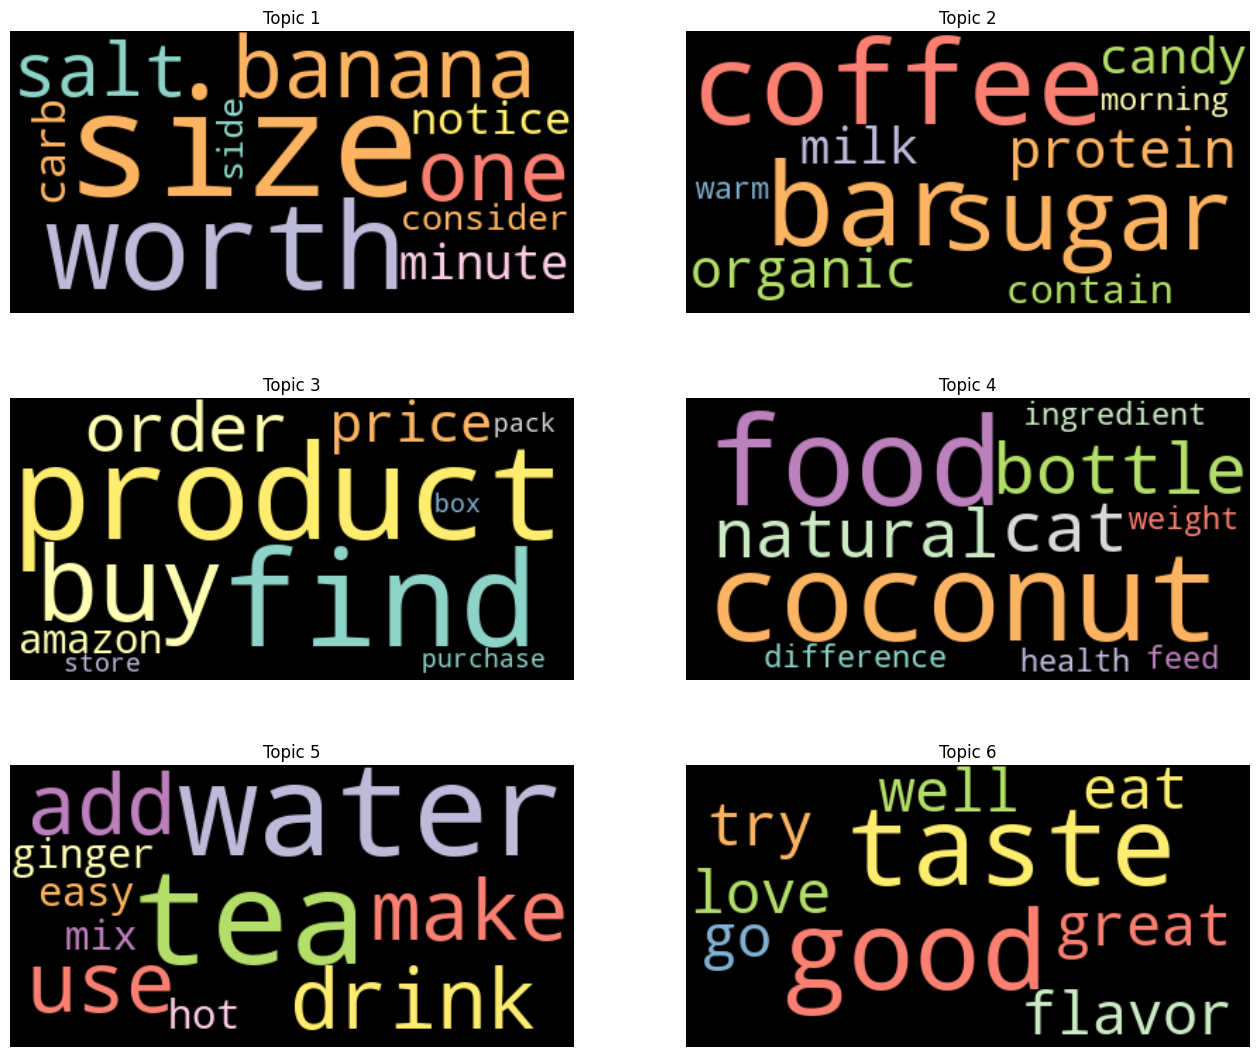

In [19]:
# topic wise wordcloud
fig = plt.figure(figsize=(16,13.5))
r,c=3,2

for i in range(6) :
    text = " ".join(str(each) for each in (0,lda_model.print_topic(i)))
    wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
    fig.add_subplot(r,c,i+1)
    # showing image
    # plt.figure(figsize=(8,4.5))
    plt.imshow(wordcloud, interpolation='Bilinear')
    plt.axis('off')
    plt.title(f"Topic {i+1}")
plt.savefig(f"figall.png")

In [20]:
# topic wise in separate image
# from wordcloud import WordCloud, ImageColorGenerator
# for i in range(6) :
#     text = " ".join(str(each) for each in (0,lda_model.print_topic(i)))
#     wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
#     plt.figure(figsize=(8,4.5))
#     plt.imshow(wordcloud, interpolation='Bilinear')
#     plt.axis("off")
#     # plt.figure(1,figsize=(12, 12))
#     # plt.show()
#     plt.savefig(f"fig{i}.png")

In [22]:
#open topics Report
import webbrowser
path = "webpage.html"
webbrowser.open(path)

True